# Exercício de Mistura Gaussiana

O objetivo desse exercício é aplicar os conceitos e o algoritmo de Mistura Gaussiana em dois exemplos. Uma aplicação com valores fictícios e outro com valores reais

## Base Criada

Criando os dados imaginários que serão utilizados para a clusterização:

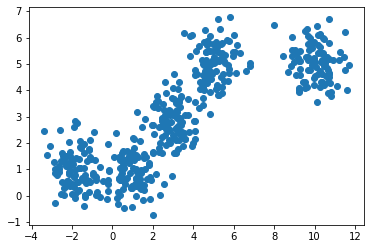

In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
position = [[3,3,1],[1,1,1],[5,5,9], [10,5,1], [-2,1,0]]
X, y = make_blobs(n_samples = 500, centers = position, cluster_std = 0.70, random_state = 42)

plt.scatter(X[:,0], X[:,1])
plt.show()

Criando uma lista para armazenar os nomes da coluna:

In [2]:
cols = ['col1', 'col2', 'col3']

Importando a biblioteca _pandas_:

In [3]:
import pandas as pd

Criando um dataset com as _features_ X e o _target_ y:

In [4]:
df = pd.DataFrame(X, columns = cols)
df['target'] = y
df.head()

,col1,col2,col3,target
0,9.956185,4.472225,0.803527,3
1,10.145868,3.570786,0.826976,3
2,9.791706,5.962995,0.894961,3
3,10.496303,4.937185,2.008082,3
4,4.598437,4.617199,8.977073,2


Transformando a coluna "_target_" em categórica:

In [5]:
df['target'] = df['target'].astype('category')

Checando a quantidade alvo de _clusters_ e os seus tamanhos:

In [6]:
df['target'].value_counts()

0    100
1    100
2    100
3    100
4    100
Name: target, dtype: int64

### 1. Análise Preliminar dos Dados

Tamanho do banco de dados:

In [7]:
df.shape

(500, 4)

Análise descritiva dos dados:

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,500.0,3.480207,4.050000,-3.376450,0.522038,3.142773,5.425008,11.682391
col2,500.0,2.980478,1.963727,-0.730151,1.142162,2.856807,4.789104,6.768853
col3,500.0,2.442319,3.418129,-1.813730,0.406809,1.086824,2.014465,10.842667


### 2. Visualização dos Dados

Importando as bibliotecas necessárias:

In [9]:
import seaborn as sns

Matriz de correlação:

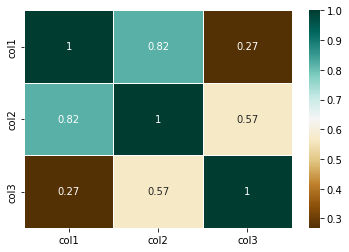

In [10]:
sns.heatmap(df[cols].corr(), annot = True, linewidths = 0.5, cmap = 'BrBG')
plt.show()

Observamos que existe uma correlação razoavelmente forte entre as colunas "col1" e "col2".

Histogramas:

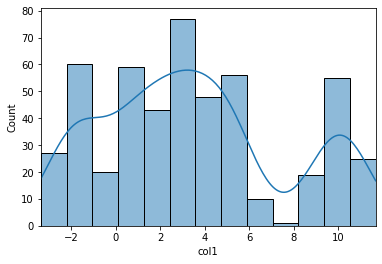

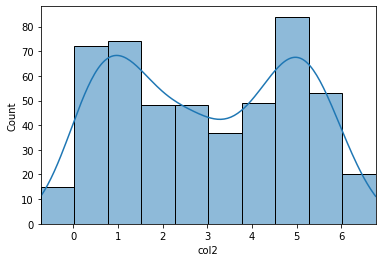

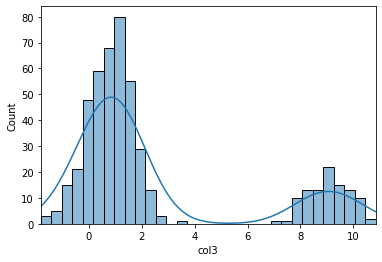

In [11]:
for i in cols:
    fig, ax = plt.subplots()
    sns.histplot(df[i], ax = ax, kde = True)
    ax.set_xlim(left = df[i].min(), right = df[i].max())
    plt.show()

Pela análise dos gráficos acima, é possível observar que os dados não seguem uma distribuição normal. Além disso, visto a distribuição presente, optaremos por uma padronização dos dados.

_Boxplots_:

<AxesSubplot:>

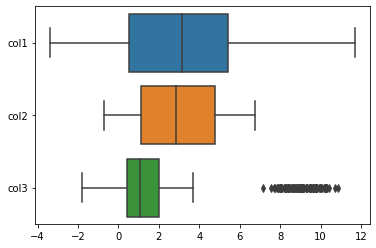

In [12]:
sns.boxplot(data = df[cols], orient = 'h')

Pelo resultado obtido acima, verificamos que a coluna "col3" possui diversos _outliers_.

_Pairplots_:

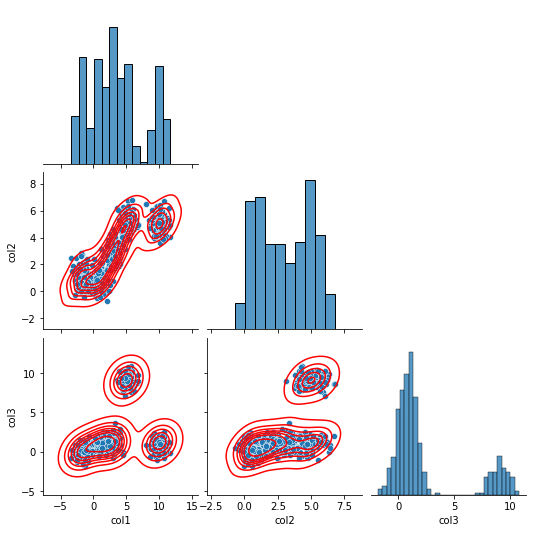

In [13]:
fig = sns.pairplot(data = df[cols], corner = True)
fig.map_offdiag(sns.kdeplot, levels = 8, color = 'r')

Os gráficos acima, plotados sem a especificação da coluna _target_, são incapazes de nos prever um bom indicativo da quantidade ideal de _clusters_ para essa base de dados.

### 3. Tratamento dos _Outliers_:

Definindo os quartis 1 e 3, e o intervalo interquartil:

In [14]:
Q1 = df['col3'].quantile(0.25)
Q3 = df['col3'].quantile(0.75)
IQR = Q3 - Q1

Criando um banco de dados "filtrado", ou seja, sem os _outliers_:

In [15]:
df_filtered = df[~((df['col3'] < (Q1 - 1.5 * IQR)) | (df['col3'] > (Q3 + 1.5 * IQR)))]

Tamanho do _dataset_ resultante:

In [16]:
df_filtered.shape

(400, 4)

A remoção dos _outliers_ significou uma remoção de 100 linhas do _dataset_ original.

#### 3.1. Visualização dos Dados (sem _Outliers_)

_Pairplots_:

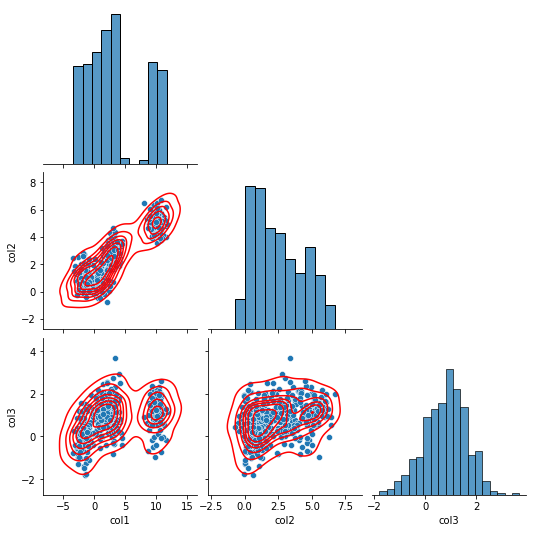

In [17]:
fig = sns.pairplot(data = df_filtered[cols], corner = True)
fig.map_offdiag(sns.kdeplot, levels = 8, color = 'r')

Checando a quantidade alvo de _clusters_ resultantes do _dataset_ filtrado e os seus tamanhos:

In [18]:
df_filtered['target'].value_counts()

0    100
1    100
3    100
4    100
2      0
Name: target, dtype: int64

Pelo dois comandos executados anteriormente, é possível perceber que o _cluster_ 2 era formado exclusivamente por dados _outliers_. Dessa forma, optaremos por manter esses elementos dessa vez.

Excluindo o _dataset_ filtrado:

In [19]:
del df_filtered

### 4. Padronização dos Dados:

Importando as bibliotecas necessárias:

In [20]:
from sklearn.preprocessing import StandardScaler

Criando o escalonador:

In [21]:
scaler = StandardScaler()

Padronizando o _dataframe_ e exibindo o resultado:

In [22]:
df_standard = pd.DataFrame(scaler.fit_transform(df.drop(columns = 'target')), columns = df.drop(columns = 'target').columns)
df_standard['target'] = df['target']
df_standard.head()

,col1,col2,col3,target
0,1.600608,0.760412,-0.479921,3
1,1.647491,0.300907,-0.473054,3
2,1.559955,1.520325,-0.453145,3
3,1.734104,0.997423,-0.127167,3
4,0.276383,0.834311,1.913707,2


### 5. Aplicando o Modelo de Mistura Gaussiana

De forma similar ao KMeans, o método de Mistura Gaussiana utiliza uma informação prévia de quantos _clusters_ o conjunto de dados pode ter. Neste caso, faremos uma análise de como ficaria os dados acima para grupos de clusterings de 2 a 6 agrupamentos, e avaliaremos qual é o melhor resultado.

Importando a biblioteca:

In [23]:
from sklearn.mixture import GaussianMixture

Criando os modelos:

In [24]:
model_gm2 = GaussianMixture(2)
model_gm6 = GaussianMixture(6)

Definindo os _clusters_ de cada modelo:

In [25]:
df_standard['cluster2'] = model_gm2.fit_predict(df_standard)
df_standard['cluster2'] = df_standard['cluster2'].astype('category')
df_standard['cluster6'] = model_gm6.fit_predict(df_standard)
df_standard['cluster6'] = df_standard['cluster6'].astype('category')

### 6. Visualizando os Resultados

Criando uma lista das possíveis combinações de todas as colunas:

In [26]:
# Importando a biblioteca necessária

from itertools import combinations

# Gerando a lista

combinacoes = list(combinations(cols, 2))

Visualizando os resultados dos dois modelos:

<AxesSubplot:title={'center':'6 Clusters - Col2 x Col3'}, xlabel='col2', ylabel='col3'>

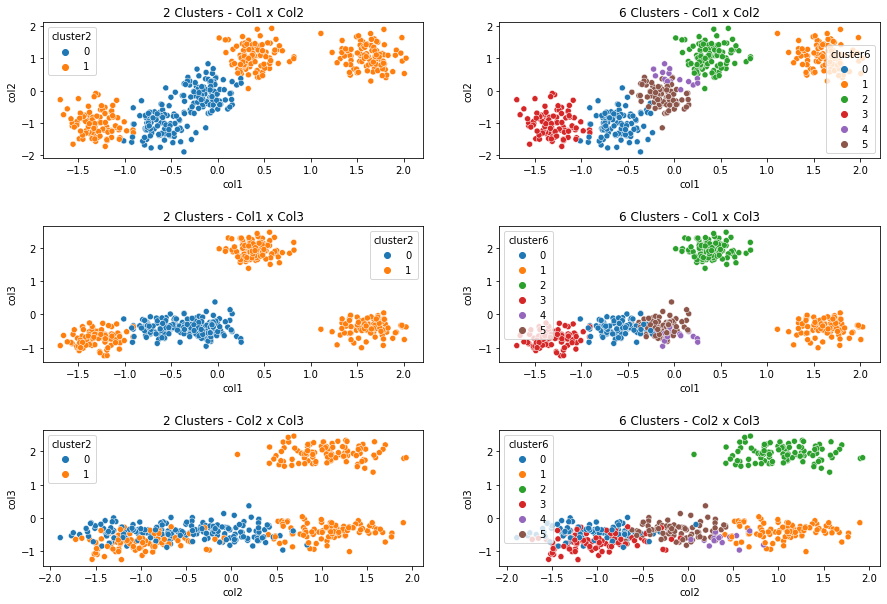

In [27]:
fig, axes = plt.subplots(3, 2, figsize = (15, 10))
plt.subplots_adjust(hspace = 0.5)
axes[0, 0].set_title('2 Clusters - Col1 x Col2')
sns.scatterplot(ax = axes[0, 0], data = df_standard, x = combinacoes[0][0], y = combinacoes[0][1], hue = 'cluster2')
axes[1, 0].set_title('2 Clusters - Col1 x Col3')
sns.scatterplot(ax = axes[1, 0], data = df_standard, x = combinacoes[1][0], y = combinacoes[1][1], hue = 'cluster2')
axes[2, 0].set_title('2 Clusters - Col2 x Col3')
sns.scatterplot(ax = axes[2, 0], data = df_standard, x = combinacoes[2][0], y = combinacoes[2][1], hue = 'cluster2')
axes[0, 1].set_title('6 Clusters - Col1 x Col2')
sns.scatterplot(ax = axes[0, 1], data = df_standard, x = combinacoes[0][0], y = combinacoes[0][1], hue = 'cluster6')
axes[1, 1].set_title('6 Clusters - Col1 x Col3')
sns.scatterplot(ax = axes[1, 1], data = df_standard, x = combinacoes[1][0], y = combinacoes[1][1], hue = 'cluster6')
axes[2, 1].set_title('6 Clusters - Col2 x Col3')
sns.scatterplot(ax = axes[2, 1], data = df_standard, x = combinacoes[2][0], y = combinacoes[2][1], hue = 'cluster6')

Ao considerarmos os gráficos plotados acima, chegamos a conclusão de que, por mais que seja possível dividir o banco de dados em mais de 2 grupos, dividí-lo em 6 é um exagero. A divisão em 6 _clusters_ proporcionou grupos mal denifinidos, como é possível perceber pela distribuição dos _clusters_ 0, 2 e 5.

## Base Real


Utilizando o dataset __clustering_gmm__, que contém informação de __altura__ e __peso__ de diversos indivíduos, iremos analisar as diferenças entre KMeans, o MeanShift e o GaussianMixture no processo de _clusterização_.

Importando e exibindo o banco de dados:

In [28]:
df = pd.read_csv(r'C:\Users\arnon\Documents\DNC\Exercícios\Clustering - Modelos Não Supervisionados II\Exercício - Gaussian Mixture\clustering_gmm.csv')
df.head()

,Weight,Height
0,67.062924,176.086355
1,68.804094,178.388669
2,60.930863,170.284496
3,59.733843,168.691992
4,65.431230,173.763679


### 1. Análise Preliminar dos Dados

Tamanho do banco de dados:

In [29]:
df.shape

(500, 2)

Percentual de nulos de cada coluna:

In [30]:
df.isnull().sum()*100/len(df)

Weight    0.0
Height    0.0
dtype: float64

Tipos de dados:

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Weight  500 non-null    float64
 1   Height  500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB


Análise descritiva dos dados:

In [32]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Weight,500.0,61.270240,5.196976,50.433644,57.772791,61.961518,65.439332,70.700456
Height,500.0,169.515781,4.805095,160.182164,166.607599,169.726252,172.837284,178.894770


### 2. Visualização dos Dados

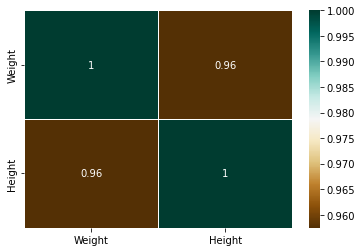

In [33]:
sns.heatmap(df.corr(), annot = True, linewidths = 0.5, cmap = 'BrBG')
plt.show()

Observamos que as variáveis são altamente correlacionadas.

Histogramas:

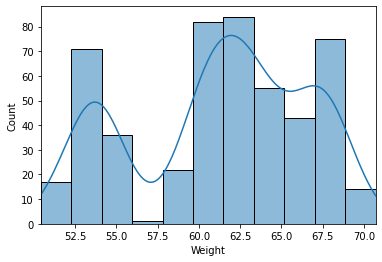

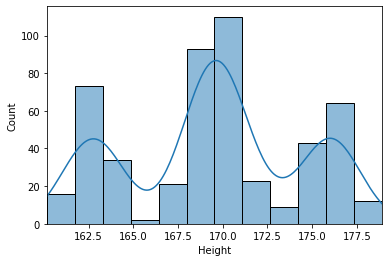

In [34]:
for i in df:
    fig, ax = plt.subplots()
    sns.histplot(df[i], ax = ax, kde = True)
    ax.set_xlim(left = df[i].min(), right = df[i].max())
    plt.show()

Pela análise dos gráficos acima, é possível observar que os dados não seguem uma distribuição normal.

_Boxplots_:

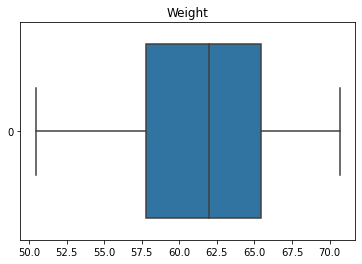

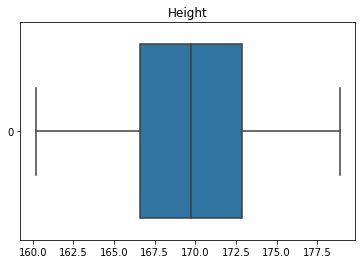

In [35]:
for i in df:
    plt.figure()
    plt.title(i)
    sns.boxplot(data = df[i], orient = 'h')
    plt.show()

A base de dados não contém _outliers_.

Gráfico de distribuição:

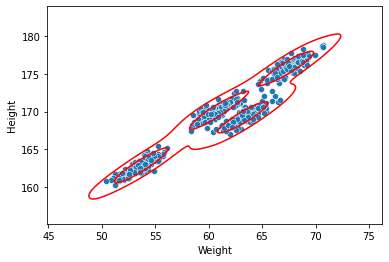

In [36]:
plt.figure()
sns.scatterplot(data = df, x = 'Weight', y = 'Height')
sns.kdeplot(data = df, x = 'Weight', y = 'Height', levels = 3, color = 'r')
plt.show()

O gráfico anterior indica que a massa de dados deve ser dividida em 4 _clusters_.

### 3. Método de Elbow e Silhueta

Aplicaremos tanto o Método de _Elbow_ quanto o Método da Silhueta para verificar a quantidade ideal de _clusters_ e comparar com a que foi indicada na etapa anterior (4).

Importando as bibliotecas necessárias:

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Aplicando os métodos:

In [38]:
inertias = []
silhouettes = []
for k in range(1, 10):
    model_km = KMeans(n_clusters = k).fit(df)
    inertias.append(model_km.inertia_)
    if k != 1:
        silhouettes.append(silhouette_score(df, model_km.predict(df)))

_Plotando_ o Método de _Elbow_:

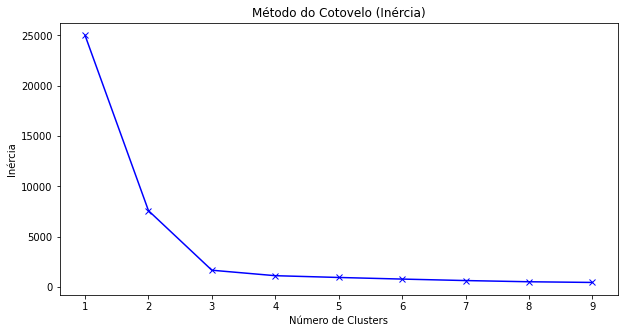

In [39]:
plt.figure(figsize = (10, 5))
plt.plot(range(1,10), inertias, 'bx-')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo (Inércia)')
plt.show()

_Plotando_ o Método da Silhueta:

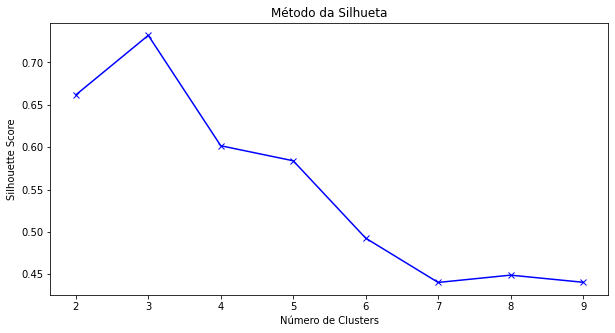

In [40]:
plt.figure(figsize = (10, 5))
plt.title('Método da Silhueta')
plt.plot(range(2, 10), silhouettes, 'bx-')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.show()

Pelos resultados obtidos nas células anteriores, fica claro que o número de _clusters_ ideal é 3 e não 4:

In [41]:
model_km = KMeans(n_clusters = 3).fit(df)

### 4. Clusterização utilizando o Kmeans

Centros dos _clusters_:

In [42]:
centros_clusters_km = pd.DataFrame(data = model_km.cluster_centers_, columns = df.columns)
centros_clusters_km.head()

,Weight,Height
0,53.600298,162.764782
1,67.480409,175.860175
2,61.911015,169.619227


Integrando os _clusters_ ao dataframe:

In [43]:
df['cluster_km'] = model_km.labels_

### 5. Clusterização utilizando o MeanShift

Importando a biblioteca necessária:

In [44]:
from sklearn.cluster import MeanShift

Criando e _fittando_ o modelo:

In [45]:
model_msc = MeanShift().fit(df.drop(columns = 'cluster_km'))

Centros dos _clusters_:

In [46]:
centros_clusters_msc = pd.DataFrame(data = model_msc.cluster_centers_, 
                                    columns = df.drop(columns = 'cluster_km').columns)
centros_clusters_msc.head()

,Weight,Height
0,62.028292,169.718197
1,67.353332,175.637863
2,53.600298,162.764782


Integrando os _clusters_ ao dataframe:

In [47]:
df['cluster_msc'] = model_msc.labels_

### 6. Clusterização Gaussiana

Criando e _fittando_ o modelo:

In [48]:
model_gm = GaussianMixture(3).fit(df.drop(columns = ['cluster_km', 'cluster_msc']))

Centro dos _clusters_:

In [49]:
centros_clusters_gm = pd.DataFrame(data = model_gm.means_,
                                    columns = df.drop(columns = ['cluster_km', 'cluster_msc']).columns)
centros_clusters_gm.head()

,Weight,Height
0,61.980097,169.655827
1,67.517908,175.983764
2,53.600334,162.764812


Integrando os _clusters_ ao dataframe:

In [50]:
df['cluster_gm'] = model_gm.predict(df.drop(columns = ['cluster_km', 'cluster_msc']))

### 7. Comparação Visual dos Modelos

Convertendo as colunas dos _clusters_ para variável "category":

In [51]:
df['cluster_km'] = df['cluster_km'].astype('category')
df['cluster_msc'] = df['cluster_msc'].astype('category')
df['cluster_gm'] = df['cluster_gm'].astype('category')

_Plotando_ os gráficos dos modelos:

<AxesSubplot:title={'center':'Método de Mistura Gaussiana'}, xlabel='Weight', ylabel='Height'>

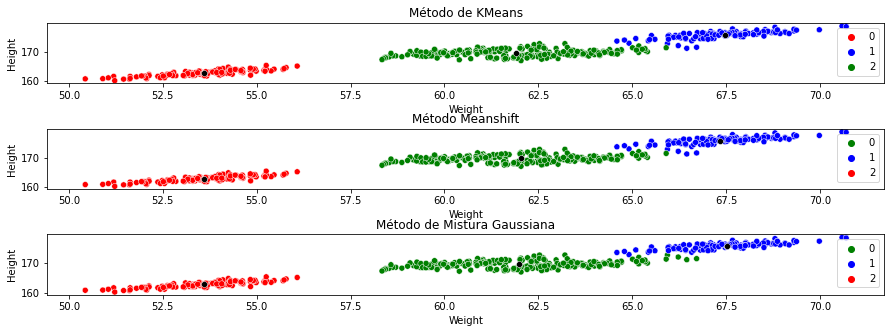

In [54]:
fig, axes = plt.subplots(3, 1, figsize = (15, 5))
axes[0].set_title('Método de KMeans')
sns.scatterplot(ax = axes[0], data = df, x = 'Weight', y = 'Height', hue = 'cluster_km', palette = ['red', 'blue', 'green'])
sns.scatterplot(ax = axes[0], data = centros_clusters_km, x = 'Weight', y = 'Height', color = 'black')
plt.subplots_adjust(hspace = 0.75)
axes[1].set_title('Método Meanshift')
sns.scatterplot(ax = axes[1], data = df, x = 'Weight', y = 'Height', hue = 'cluster_msc', palette = ['green', 'blue', 'red'])
sns.scatterplot(ax = axes[1], data = centros_clusters_msc, x = 'Weight', y = 'Height', color = 'black')
axes[2].set_title('Método de Mistura Gaussiana')
sns.scatterplot(ax = axes[2], data = df, x = 'Weight', y = 'Height', hue = 'cluster_gm', palette = ['green', 'blue', 'red'])
sns.scatterplot(ax = axes[2], data = centros_clusters_gm, x = 'Weight', y = 'Height', color = 'black')